# 30分足で、N足以内の値動きの分析

## 目的
- ランダムに仕掛けた場合の、保有期間と損益の関係を明らかにすること
    - これをベースとして、これよりも総損益が大きくなる買い仕掛けを発見すればよい
    - もしランダム仕掛けでも総損益がプラスなら、それをそのまま使う方法もある

## 目標
- 保有期間と値動きの関係を明らかにすること

## 仮説
- 仮説1：保有期間を長くするほど最大値動きは大きい
    - 仮説が正しければ、仕掛け後に目標価格で手仕舞う場合、保有期間が長いほど目標価格を高く設定できる
- 仮説2：保有期間を長くするほど、一定値以上の上昇を捉えられる確率が上がる
    - 仮説が正しければ、仕掛け後に一定値上昇した目標価格で手仕舞う場合、保有期間が長いほど勝率が上がる

## 分析内容
- 横軸に保有期間、縦軸に保有期間内の**最高値**の分布を取ったグラフを描く
- 横軸に保有期間、縦軸に保有期間内の**最安値**の分布を取ったグラフを描く

## 結果・考察
- 保有期間が長いほど最大上昇幅の平均値・中央値ともに大きくなる。
    - --> 目標価格を一定にする場合、保有期間が長いほど目標価格到達確率は高くなる
    - --> 到達価格を一定にする場合、保有期間が長いほど目標価格は高くなる
- 勝率を計算するためには、手仕舞いルールを定めたうえで、その手仕舞いでの損益がプラスになる割合を計算する必要がある
    - 例：コストを\\$4とすれば、仕掛けからN足以内に損益がプラス\\$5以上になる確率を計算すれば、それがランダム戦略での最大勝率となる。（最大損益戦略ではない）
- 総損益を計算するためには、手仕舞いルールを定めたうえで、その手仕舞いでの損益の総和を計算する必要がある

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed
from functools import reduce

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

# データ読み込み

In [9]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-30min.csv')

# 分析用データ作成

In [93]:
df = df_sp_raw.copy()

# DateTime列を追加
df['DT'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))

# 1997と2020はデータが不十分のため除く
df = df[(df['DT']>dt.datetime(1998,1,1)) & (df['DT']<dt.datetime(2020,1,1))]
df = df.reset_index(drop=True)

# 値動き（終値 - 始値）列を追加
df['CODiff'] = df['Close'] - df['Open']

# 年の列を追加
df['year'] = df['DT'].map(lambda d: d.year)

# 年の順序付け
year_type = CategoricalDtype(categories=range(df['year'].min(), df['year'].max()+1), ordered=True)
df['year'] = df['year'].astype(year_type)

In [94]:
# 上昇、不変、下落
df['isUp'] = df['CODiff'] > 0
df['isFlat'] = df['CODiff'] == 0
df['isDown'] = df['CODiff'] < 0

In [95]:
def price_range_in_n_periods(df, periods):
    dfs = []
    for p in periods:
        df_tmp = fl.make_nbars_future(df, p-1, cols=['Close', 'High', 'Low'])
        df_tmp['HODiff'] = df_tmp[[f'High{i}' for i in range(p)]].max(axis=1) - df_tmp['Open']
        df_tmp['LODiff'] = df_tmp[[f'Low{i}' for i in range(p)]].min(axis=1) - df_tmp['Open']
        df_tmp['period'] = p
        df_tmp = df_tmp[['HODiff', 'LODiff', 'period']]
        dfs.append(df_tmp)

    return pd.concat(dfs)

In [115]:
# 1足以内の値動き
df['HODiff'] = df['High'] - df['Open']
df['LODiff'] = df['Low'] - df['Open']
df1 = df[['HODiff', 'LODiff']]
df1['period'] = 1

periods = [2, 4, 8, 16, 32, 64, 128, 256]
price_range_df = price_range_in_n_periods(df, periods)
price_range_df = pd.concat([df1, price_range_df])
price_range_df = price_range_df.reset_index(drop=True)

<ipython-input-115-3fd09db96830>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['period'] = 1


In [116]:
price_range_df['periodT'] = '0.5H'
for p in periods:
    price_range_df.loc[price_range_df['period']==p, 'periodT'] = f'{p//2}H'

In [117]:
price_range_df_mean = price_range_df.groupby('period').mean()
price_range_df_mean

,HODiff,LODiff
period,,
1,1.420699,-1.445200
2,2.039374,-2.087654
4,2.927820,-3.024708
8,4.236524,-4.417098
16,6.177289,-6.506380
32,9.093472,-9.701310
64,12.959622,-14.012530
128,18.346793,-20.139058
256,25.813953,-28.612571


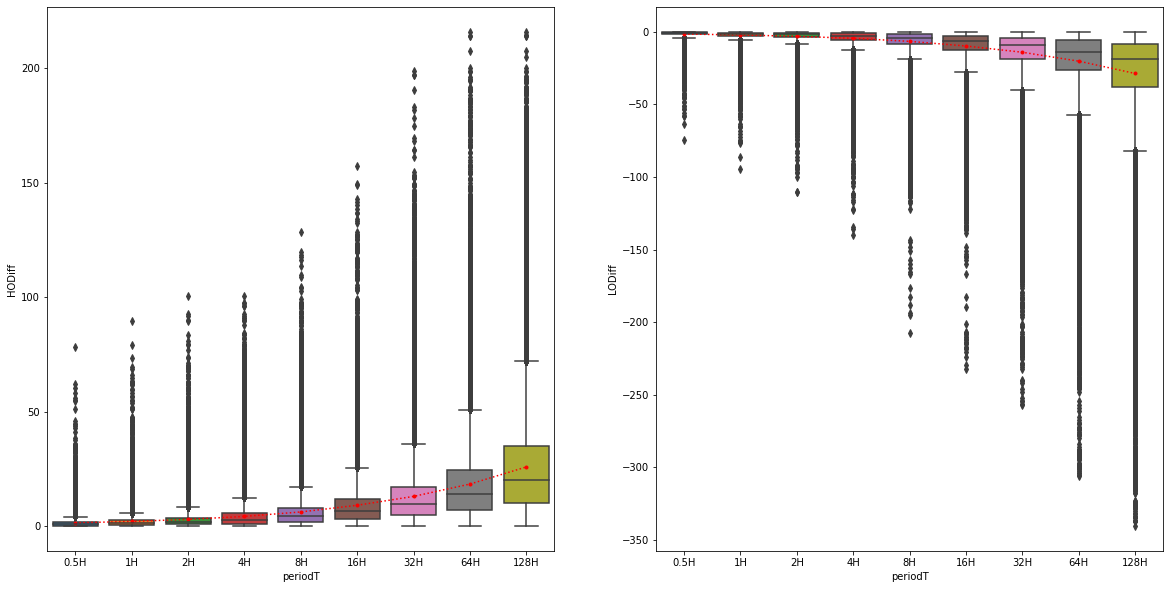

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot('periodT', 'HODiff', data=price_range_df, ax=ax[0])
ax[0].plot(range(price_range_df_mean.shape[0]), price_range_df_mean['HODiff'], marker='.', linestyle=':', color='red')
sns.boxplot('periodT', 'LODiff', data=price_range_df, ax=ax[1])
ax[1].plot(range(price_range_df_mean.shape[0]), price_range_df_mean['LODiff'], marker='.', linestyle=':', color='red')

(-30.0, 0.0)

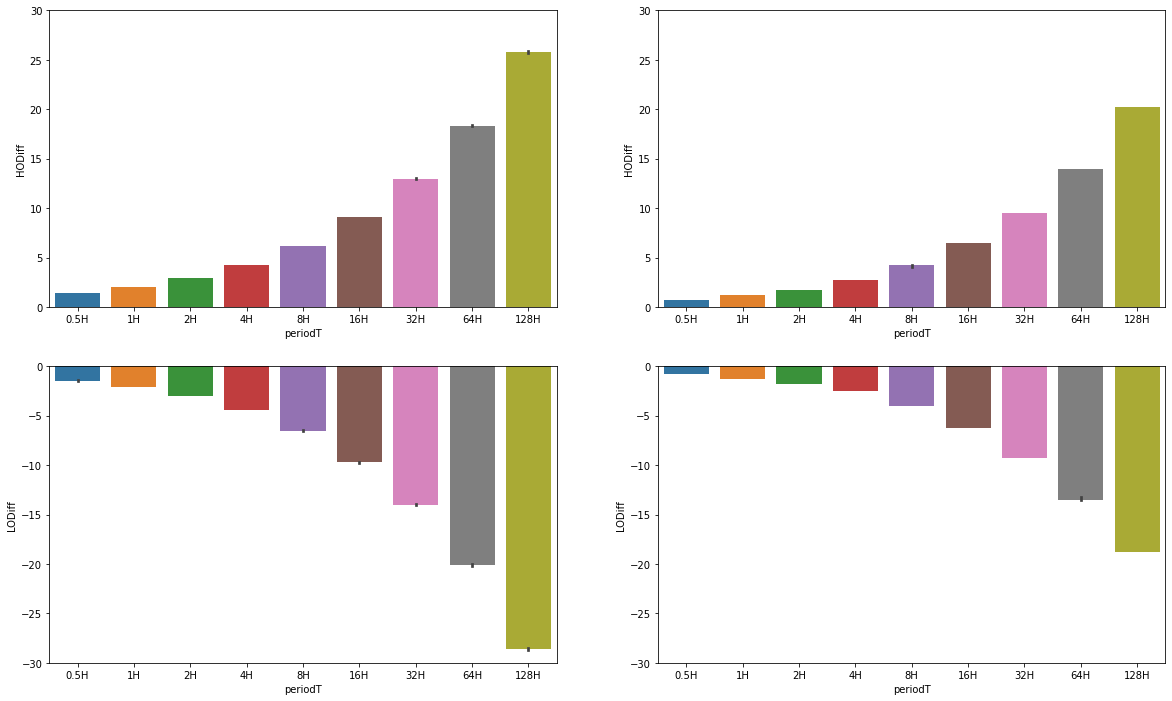

In [127]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
sns.barplot('periodT', 'HODiff', data=price_range_df, ax=ax[0,0])
ax[0,0].set_ylim(0, 30)
sns.barplot('periodT', 'HODiff', data=price_range_df, ax=ax[0,1], estimator=np.median)
ax[0,1].set_ylim(0, 30)
sns.barplot('periodT', 'LODiff', data=price_range_df, ax=ax[1,0])
ax[1,0].set_ylim(-30, 0)
sns.barplot('periodT', 'LODiff', data=price_range_df, ax=ax[1,1], estimator=np.median)
ax[1,1].set_ylim(-30, 0)